# 0. Setup

In [1]:
GoogleColab = False

# Verify we're in the correct working directory
import os
from pathlib import Path


if GoogleColab:
  ## mount connection to personal drive
  from google.colab import drive
  drive.mount('/content/drive')

  ## root directory:
  root = "/content/drive/MyDrive/"

  !pip install gitpython
  import git

  root = "/content/drive/MyDrive/dmPC/scripts_model"

else: 
  # Verify we're in the correct working directory

  import git 

  def get_project_root():
      return Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

  root = get_project_root()


os.chdir(root)
os.getcwd()

'/Users/seraphinashi/Desktop/dmPC'

In [2]:
GoogleColab = True
if GoogleColab:
  plot_folder = "../results/images/simulations/"
else:
  plot_folder = "results/images/simulations/"

## import packages, models, trainers

In [3]:
# pip install modin
# pip install -U ray

In [4]:
import argparse
import logging
import sys
import time
import warnings

import numpy as np
# import pandas as pd
import modin.pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

import ray
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print('pytorch version:', torch.__version__)
print('orig num threads:', torch.get_num_threads())

2023-11-19 20:28:30,982	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.3 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


pytorch version: 1.13.1
orig num threads: 4


In [5]:
from models import *
from trainers import *
from losses import *
from utils import *

In [6]:
import random
seed=42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Prepare dataset

## Load 

In [7]:
simu_folder = "data/simulations"
RNAseq = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq.csv"), index_col = 0)
RNAseq_meta = pd.read_csv(os.path.join(simu_folder, "simu2_RNAseq_meta.csv"), index_col = 0)
d_fp = pd.read_csv(os.path.join(simu_folder, "simu2_d_fp.csv"), index_col = 0)
# cdr = pd.read_csv(os.path.join(simu_folder, "simu2_cdr.csv"), index_col = 0)
cdr = pd.read_csv(os.path.join(simu_folder, "simu2_cdr_noise.csv"), index_col = 0)

In [8]:
RNAseq_meta['C_type'] = RNAseq_meta['C_type'].replace('grp3', 'grp0')

In [9]:
c_data = RNAseq.T

# originally
c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)

print(f"Cancer type coding map: ")
print(meta_map)

d_data = d_fp.T

cdr = cdr
cdr.index = cdr.index.astype("str")

Cancer type coding map: 
  C_type  code  count
0   grp0     0     62
4   grp1     1     35
8   grp2     2     41


In [10]:
num_cluster = 3

# only two groups
two_grp = True
if two_grp:
    num_cluster = 2
    RNAseq_meta.loc[RNAseq_meta.C_type=='grp2', 'C_type'] = 'grp1'
    
    c_meta_true = c_meta
    c_meta, meta_map = get_CCL_meta_codes(RNAseq.columns.values, RNAseq_meta)
    print(f"Cancer type coding map: ")
    print(meta_map)

Cancer type coding map: 
  C_type  code  count
0   grp0     0     62
3   grp1     1     76


## Train & Test split

In [11]:
c_train, c_test = train_test_split(c_data, test_size=0.15)

c_meta_train = get_CCL_meta(c_train.index.values, c_meta)
c_meta_test = get_CCL_meta(c_test.index.values, c_meta)

cdr_train_idx = np.isin(cdr.index.values, c_train.index.values)
cdr_train = cdr[cdr_train_idx]
cdr_test = cdr[~cdr_train_idx]

if two_grp:
    c_meta_train_true = get_CCL_meta(c_train.index.values, c_meta_true)
    c_meta_test_true = get_CCL_meta(c_test.index.values, c_meta_true)

In [12]:
print(f"Training data: \n   cdr: {cdr_train.shape}\n   c_data: {c_train.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_train_true['code'], c_meta_train['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_train['code'].value_counts())

print(f"\nTesting data:  \n   cdr: {cdr_test.shape}\n   c_data: {c_test.shape} \n   d_data: {d_data.shape}")
print(f"   Number of each initial cancer clusters: \n")
if two_grp:
    print(pd.crosstab(c_meta_test_true['code'], c_meta_test['code'], margins=True, margins_name="Total"))
else:
    print(c_meta_test['code'].value_counts())


Training data: 
   cdr: (117, 30)
   c_data: (117, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code    0   1  Total
code                
0      54   0     54
1       0  30     30
2       0  33     33
Total  54  63    117

Testing data:  
   cdr: (21, 30)
   c_data: (21, 355) 
   d_data: (30, 150)
   Number of each initial cancer clusters: 

code   0   1  Total
code               
0      8   0      8
1      0   5      5
2      0   8      8
Total  8  13     21


# 2. Hyperparameters

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(device)
print(device)

cpu


In [14]:
class Train_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    valid_size = 0.2 #@param {type: "float"}

    n_epochs = 100 #@param {type: "integer"}
    batch_size = 50 #@param {type: "integer"}
    lr = 0.01 #@param {type: "float"}
    
    C_VAE_loss_weight = 0.2 #@param {type: "float"}
    C_recon_loss_weight = 1 #@param {type: "float"}
    C_kld_weight = 1 #@param {type: "float"}
    C_cluster_distance_weight = 150 #@param {type: "float"}
    C_update_ratio_weight = 1e+04 #@param {type: "float"} # 10
    
    D_VAE_loss_weight = 0.5 #@param {type: "float"}
    D_recon_loss_weight = 1.5 #@param {type: "float"}
    D_kld_weight = 1 #@param {type: "float"}
    D_cluster_distance_weight = 100 #@param {type: "float"}
    D_update_ratio_weight = 1e+03 #@param {type: "float"} # 10
    
    predict_loss_weight = 1000 #@param {type: "float"}
    
    cVAE_save_path = 'data/model_fits/GDSC_simu2_c_vae' #@param
    dVAE_save_path = 'data/model_fits/GDSC_simu2_d_vae' #@param
    
    c_p_save_path = 'data/model_fits/GDSC_simu2_c_vae_predictor' #@param
    d_p_save_path = 'data/model_fits/GDSC_simu2_d_vae_predictor' #@param
    

class CDPModel_sub_Args:
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __contains__(self, key):
        return hasattr(self, key)

    # c_VAE
    c_input_dim = 0 #@param {type: "integer"}
    c_h_dims = [64] #@param {type: "vactor"}
    c_latent_dim = 32 #@param {type: "integer"}

    # d_VAE
    d_input_dim = 0 #@param {type: "integer"}
    d_h_dims = [64]  #@param {type: "vactor"}
    d_latent_dim = 32 #@param {type: "integer"}

    # predictor
    p_sec_dim = 16 #@param {type: "integer"}
    p_h_dims = [p_sec_dim*2, 16]  #@param {type: "vactor"}
    
    # all
    drop_out = 0  #@param {type: "float"}
    
    # sensitive threshold
    sens_cutoff = 0.5


In [15]:
train_args = Train_Args()

K = len(c_meta['code'].unique())

CDPmodel_args = CDPModel_sub_Args()
CDPmodel_args['c_input_dim'] = c_data.shape[1] 
CDPmodel_args['d_input_dim'] = d_data.shape[1]

if CDPmodel_args['c_input_dim'] <= 0:
  warnings.warn(
      '''\nCancer Cell line feature number not specified''')
if CDPmodel_args['d_input_dim'] <= 0:
  warnings.warn(
      '''\nDrug feature number not specified''')

# 3. Train Model

In [16]:
CDPmodel = CDPmodel(K, CDPmodel_args)

In [17]:
start_time = time.time()

n_rounds = 2
fit_returns = CDPmodel.fit(c_train, c_meta_train, d_data, cdr_train, train_args, n_rounds=n_rounds, search_subcluster = True, device = device)

end_time = time.time()
duration = end_time - start_time
print("Took {} minutes to train".format(round(duration / 60, 2)))

=> Initialize C-VAE:
        Best epoc with test loss: epoch 87
        Running time: 1.0926415920257568
=> Initialize D-VAE:
        Best epoc with test loss: epoch 59
        Running time: 0.4223508834838867
########################################################
#### 0. k = 0                                     
########################################################
  === 0.1. Training local CDP model 
     -- round 0 -------------
       a. Training D_VAE and Predictor
            Best epoc with test loss: epoch 14
            Running time: 33.14178991317749
       b. 10 sensitive drug(s)
       c. Training C_VAE and Predictor
            Best epoc with test loss: epoch 11
            Running time: 28.84925389289856
       d. 54 cancer cell line(s) in the cluster
     -- round 1 -------------
       a. Training D_VAE and Predictor
            Best epoc with test loss: epoch 16
            Running time: 31.13387179374695
       b. 10 sensitive drug(s)
       c. Training C_VAE and

In [18]:
c_meta, c_meta_hist, d_sens_hist, losses_train_hist_list, best_epos_list, C_VAE_init_losses, D_VAE_init_losses, c_latent_list, d_latent_list = fit_returns

# 4. Results and visualizations

## 4.1. Prediction:

### Training data:

In [19]:
cdr_train_hat = CDPmodel.predict(c_train, d_data)

cdr_train_rslt = cdr_train.copy()
cdr_train_rslt['c_name'] = cdr_train_rslt.index.values
cdr_train_rslt = pd.melt(cdr_train_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_train_rslt = cdr_train_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_train_rslt = pd.merge(cdr_train_rslt, cdr_train_hat, on=['c_name', 'd_name'], how='outer')

In [20]:
# Binary cross entropy
cdr_train_rslt_noNA = cdr_train_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_train = log_loss(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {binary_cross_entropy_train}")


# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat'])
print("ROC AUC:", roc_auc)

# confusion_ atrix
cdr_train_rslt_noNA['cdr_hat_bnr'] = (cdr_train_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_train_rslt_noNA['cdr'], cdr_train_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")

Binary cross entropy: 3.87848377071995
ROC AUC: 0.8360099772793071

True Positive:  791 (67.96 %)
False Negative: 373 (32.04 %)
True Negative:  2151 (98.49 %)
False Positive: 33 (1.51 %)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
cdr_train_hat.to_csv(os.path.join(simu_folder, "GDSC_simu2_cdr_hat_train.csv"), index=True)

### Testing data

In [22]:
cdr_test_hat = CDPmodel.predict(c_test, d_data, sd_scale = 6)

cdr_test_rslt = cdr_test.copy()
cdr_test_rslt['c_name'] = cdr_test_rslt.index.values
cdr_test_rslt = pd.melt(cdr_test_rslt, id_vars='c_name', value_vars=None, var_name=None, value_name='value', col_level=None)
cdr_test_rslt = cdr_test_rslt.rename(columns={'variable':'d_name', 'value':'cdr'})

cdr_test_rslt = pd.merge(cdr_test_rslt, cdr_test_hat, on=['c_name', 'd_name'], how='outer')

In [23]:
cdr_test_hat['cluster'].value_counts()

cluster
0        251
1        191
-1       187
0 & 1      1
Name: count, dtype: int64

In [24]:
cdr_test_hat

,c_name,d_name,cdr_hat,cdr_all,cluster,c_cluster,d_cluster
0,c0_14,d1_1,0.998145,0.998145,0,0,-1
1,c0_14,d1_2,0.998329,0.998329,0,0,-1
2,c0_14,d1_3,0.99831,0.99831,0,0,-1
3,c0_14,d1_4,0.9966,0.9966,0,0,-1
4,c0_14,d1_5,0.99849,0.99849,0,0,-1
...,...,...,...,...,...,...,...
625,c0_34,d0_6,0.999808,0.999808,0,0,0
626,c0_34,d0_7,0.999415,0.999415,0,0,0
627,c0_34,d0_8,0.999743,0.999743,0,0,0
628,c0_34,d0_9,0.999921,0.999921,0,0,0


In [25]:
# Binary cross entropy
cdr_test_rslt_noNA = cdr_test_rslt.dropna(subset=['cdr_hat', 'cdr'])
binary_cross_entropy_test = log_loss(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print(f"Binary cross entropy: {binary_cross_entropy_test}")

# Area Under the Curve (AUC) for a Receiver Operating Characteristic (ROC) 
roc_auc = roc_auc_score(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat'])
print("ROC AUC:", roc_auc)

# confusion_ atrix
cdr_test_rslt_noNA['cdr_hat_bnr'] = (cdr_test_rslt_noNA['cdr_hat'] > 0.5).astype(int)

conf_matrix = confusion_matrix(cdr_test_rslt_noNA['cdr'], cdr_test_rslt_noNA['cdr_hat_bnr'])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"\nTrue Positive:  {tp} ({(tp / (tp + fn)) * 100:.2f} %)")
print(f"False Negative: {fn} ({(fn / (fn + tp)) * 100:.2f} %)")

print(f"True Negative:  {tn} ({(tn / (tn + fp)) * 100:.2f} %)")
print(f"False Positive: {fp} ({(fp / (fp + tn)) * 100:.2f} %)")


Binary cross entropy: 4.611921910556193
ROC AUC: 0.5247981137636311

True Positive:  178 (79.11 %)
False Negative: 47 (20.89 %)
True Negative:  130 (34.48 %)
False Positive: 247 (65.52 %)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 4.2. Clustering
### Trainning data

In [26]:
c_meta_train_tmp = c_meta_train.loc[:, ['code']]
c_meta_train_tmp['c_name'] = c_meta_train_tmp.index.values.astype(str)
c_meta_train_tmp = c_meta_train_tmp.rename(columns={'code':'cluster_init'})

cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

print("CD-bicluster:")
if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_train_rslt_cluster['cluster_true'], cdr_train_rslt_cluster['cluster_init']], cdr_train_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['cluster']))


CD-bicluster:
cluster                    -1   0   1
cluster_true cluster_init            
0            0             54  54   0
1            1             30   0   0
2            1             33   0  33


In [27]:
cdr_train_rslt_tmp = cdr_train_rslt[['c_name', 'c_cluster']]
cdr_train_rslt_tmp = cdr_train_rslt_tmp.drop_duplicates()
cdr_train_rslt_tmp['c_name'] = cdr_train_rslt_tmp['c_name'].astype(str)

cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_tmp, c_meta_train_tmp, on='c_name', how='left')

print("Cancer cluster:")
if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_train_rslt_cluster = pd.merge(cdr_train_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_train_rslt_cluster['cluster_true'], cdr_train_rslt_cluster['cluster_init']], cdr_train_rslt_cluster['c_cluster']))
else:
    print(pd.crosstab(cdr_train_rslt_cluster['cluster_init'], cdr_train_rslt_cluster['c_cluster']))


Cancer cluster:
c_cluster                  -1   0   1
cluster_true cluster_init            
0            0              0  54   0
1            1             30   0   0
2            1              0   0  33


In [28]:
print('Sensitive to clusters before:')
print(d_sens_hist.sensitive_k.value_counts())
print('Sensitive to clusters after:')
print(d_sens_hist.sensitive_k_latest.value_counts())

Sensitive to clusters before:
sensitive_k
-1    13
0     10
1      7
Name: count, dtype: int64
Sensitive to clusters after:
sensitive_k_latest
-1    10
1     10
0     10
Name: count, dtype: int64


### Testing data

In [29]:
c_meta_test_tmp = c_meta_test.loc[:, ['code']]
c_meta_test_tmp['c_name'] = c_meta_test_tmp.index.values.astype(str)
c_meta_test_tmp = c_meta_test_tmp.rename(columns={'code':'cluster_init'})

cdr_test_rslt_tmp = cdr_test_rslt[['c_name', 'cluster']]
cdr_test_rslt_tmp = cdr_test_rslt_tmp.drop_duplicates()
cdr_test_rslt_tmp['c_name'] = cdr_test_rslt_tmp['c_name'].astype(str)


cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_tmp, c_meta_test_tmp, on='c_name', how='left')

print("CD-bicluster:")

if two_grp:
    cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab([cdr_test_rslt_cluster['cluster_true'], cdr_test_rslt_cluster['cluster_init']], cdr_test_rslt_cluster['cluster']))
else:
    print(pd.crosstab(cdr_test_rslt_cluster['cluster_init'], cdr_test_rslt_cluster['cluster']))
    

CD-bicluster:
cluster                    -1  0  0 & 1  1
cluster_true cluster_init                 
0            0              1  8      1  0
1            1              4  1      0  2
2            1              3  1      0  8


In [30]:
cdr_test_rslt_tmp = cdr_test_rslt[['c_name', 'c_cluster']]
cdr_test_rslt_tmp = cdr_test_rslt_tmp.drop_duplicates()
cdr_test_rslt_tmp['c_name'] = cdr_test_rslt_tmp['c_name'].astype(str)

cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_tmp, c_meta_test_tmp, on='c_name', how='left')

print("Cancer cluster:")
if two_grp:
    c_meta_true_tmp = c_meta_true.loc[:, ['code']]
    c_meta_true_tmp['c_name'] = c_meta_true_tmp.index.values.astype(str)
    c_meta_true_tmp = c_meta_true_tmp.rename(columns={'code':'cluster_true'})

    cdr_test_rslt_cluster = pd.merge(cdr_test_rslt_cluster, c_meta_true_tmp, on='c_name', how='left')
    
    print(pd.crosstab(cdr_test_rslt_cluster['cluster_true'], cdr_test_rslt_cluster['c_cluster']))



Cancer cluster:
c_cluster     -1  0  1
cluster_true          
0              1  7  0
1              4  1  0
2              3  0  5


## Visualizations

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

from visuals import *

### Trainning data:

FileNotFoundError: [Errno 2] No such file or directory: '../results/images/simulations/simu2_2clusters_c_latent_k0.png'

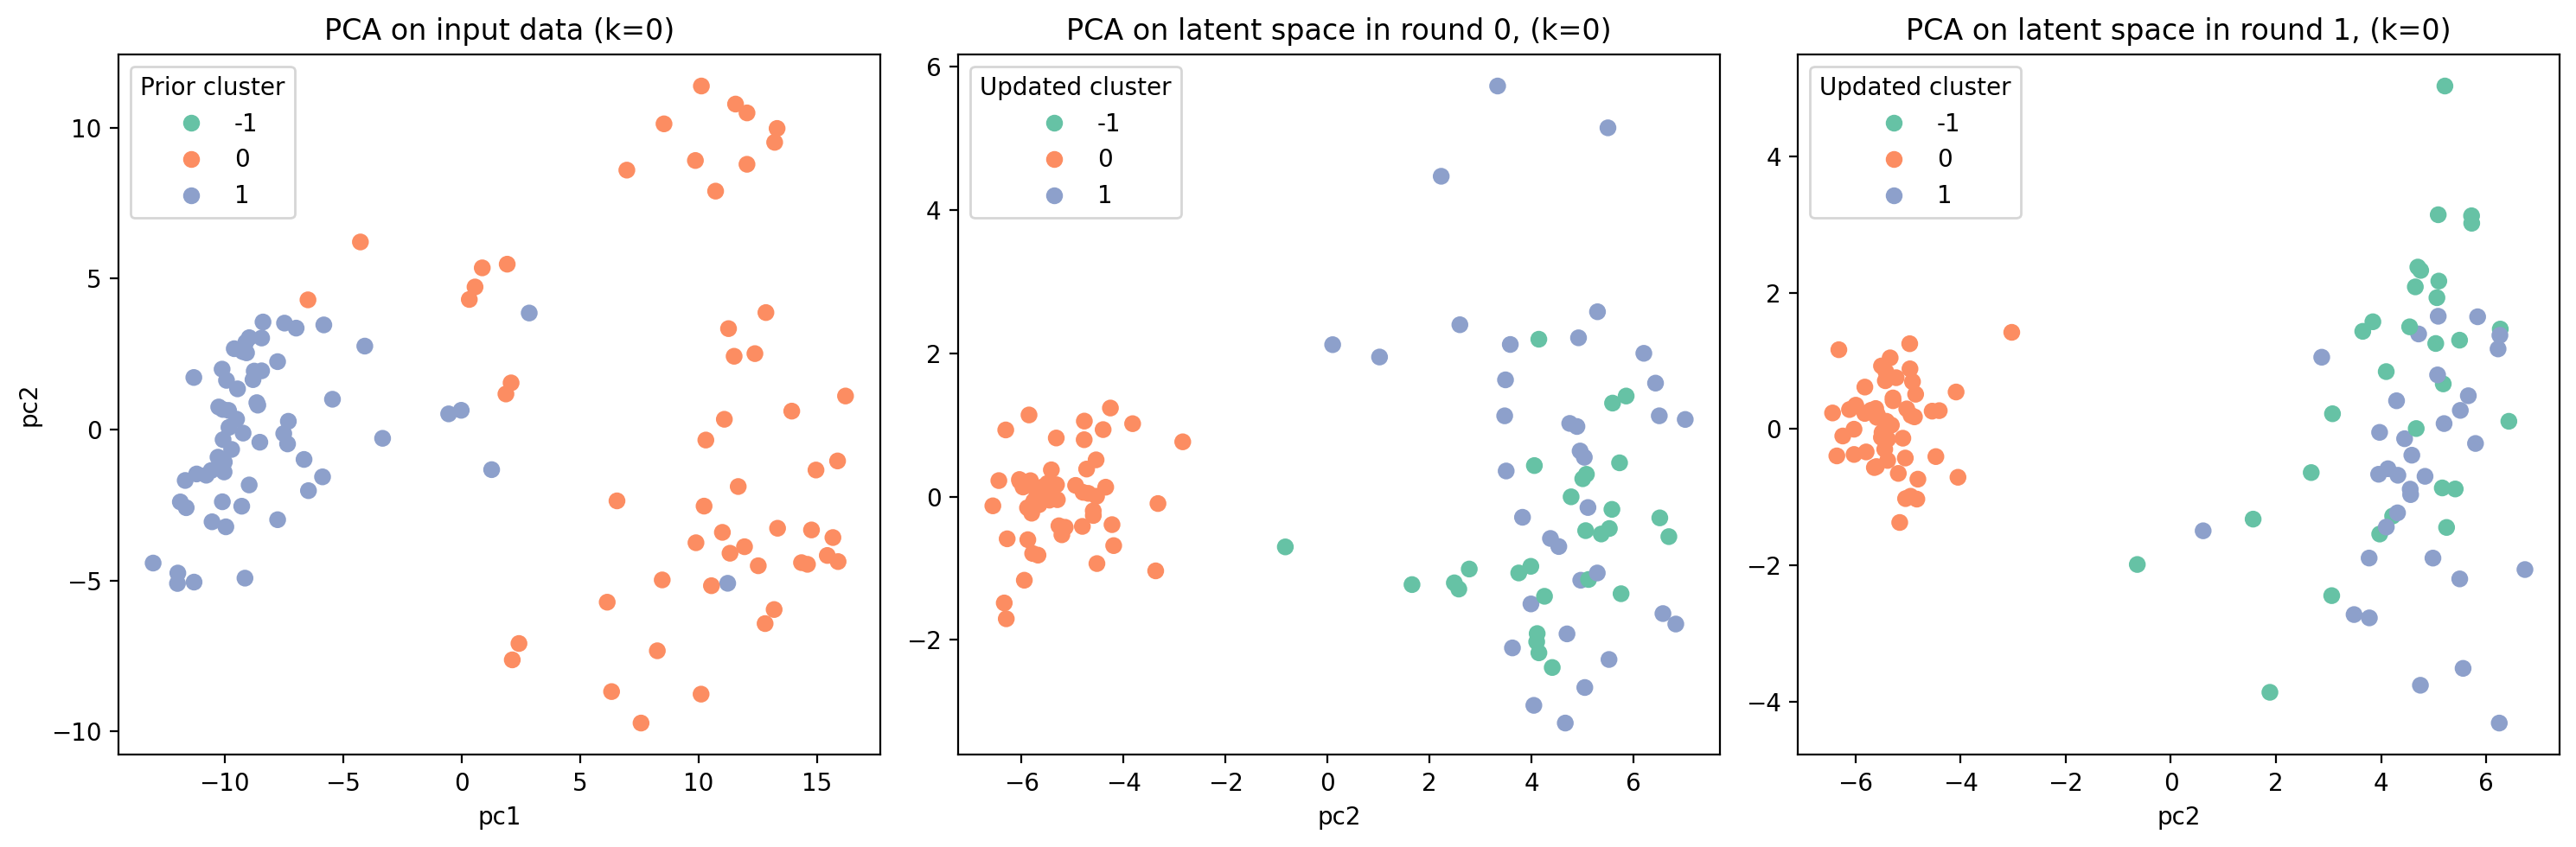

In [32]:
plot_c_PCA_latent(c_train, n_rounds, fit_returns, model=CDPmodel, plots_save_path=f'{plot_folder}simu2_{num_cluster}clusters_c_latent')

# for k in range(K):
#    plot_c_PCA_latent(c_train, c_latent_list, c_meta_hist, n_rounds, legend_title='cluster', k=k, 
#                      plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_c_latent_k{k}.png')

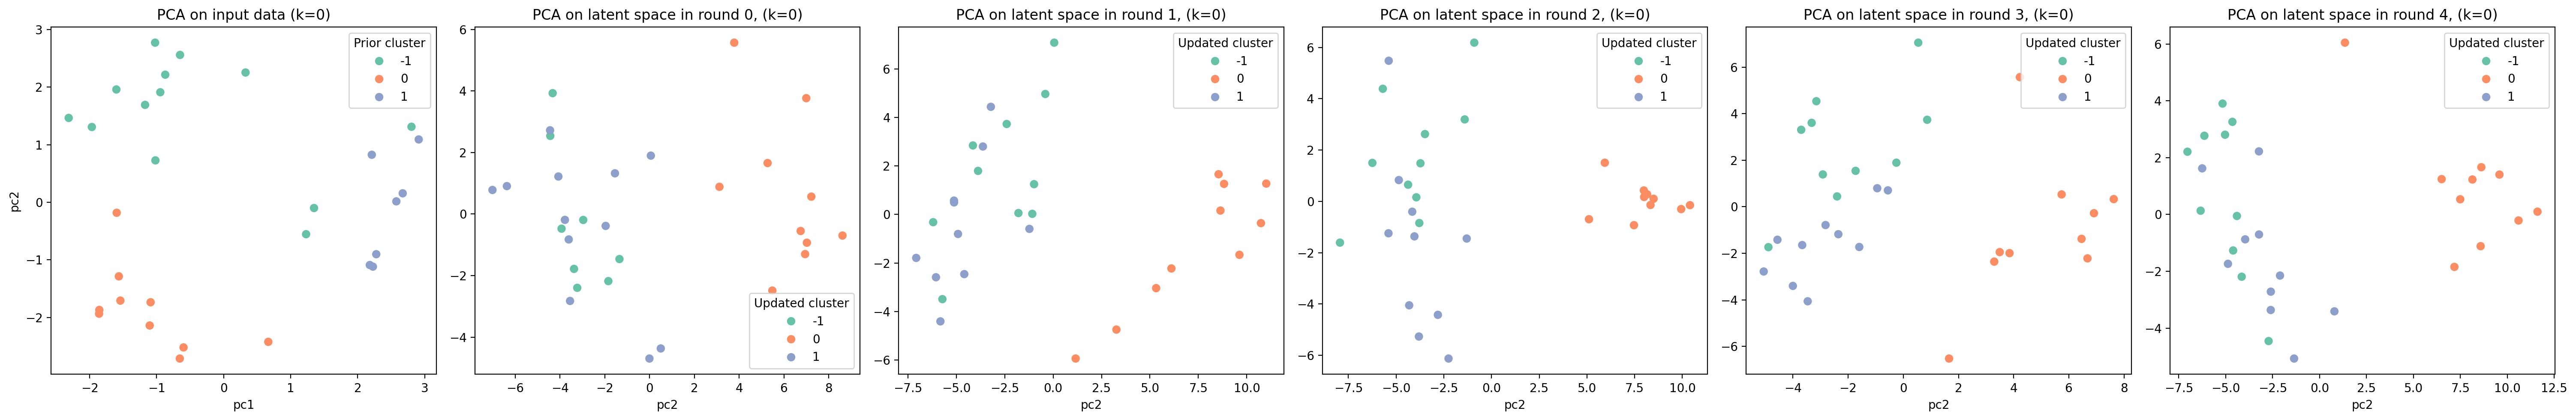

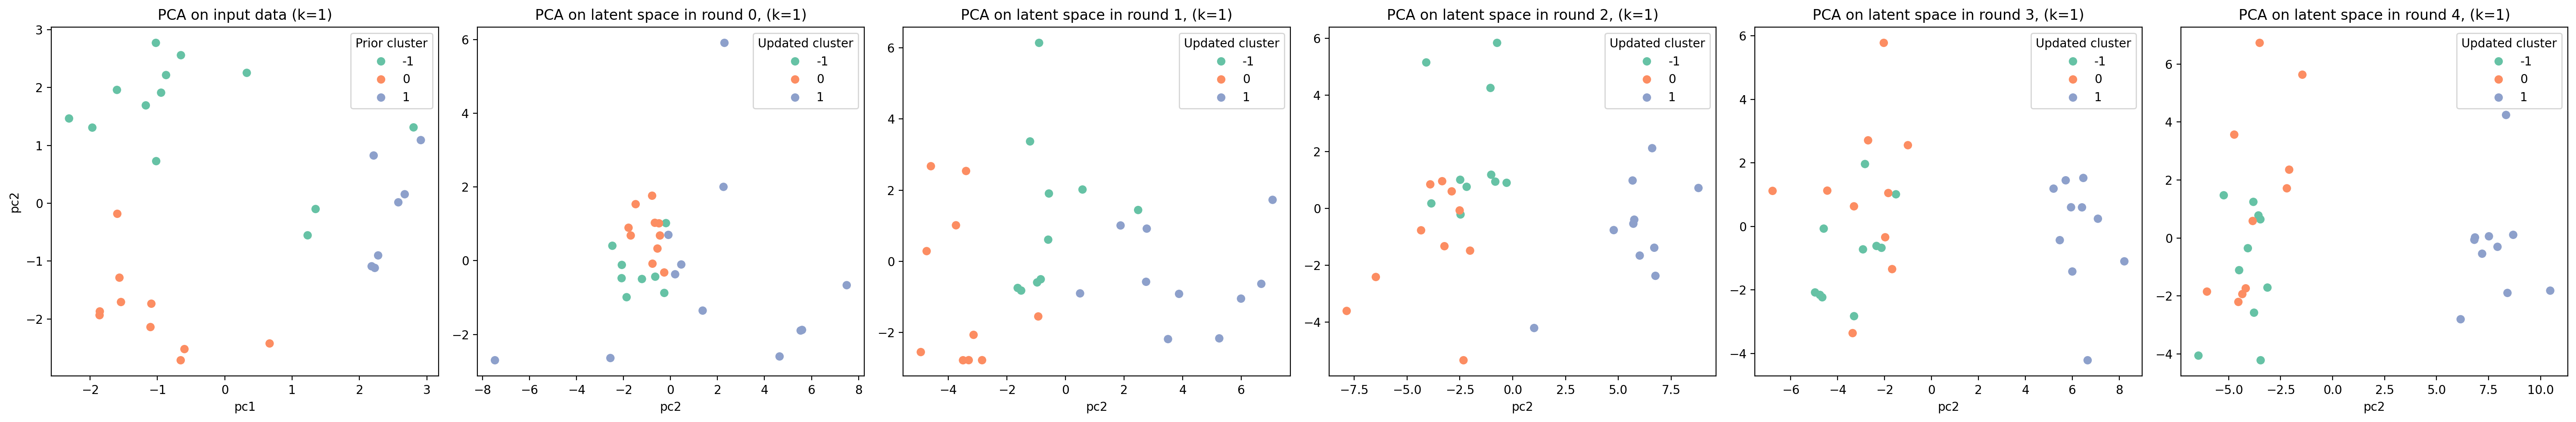

In [ ]:
plot_d_PCA_latent(d_data, n_rounds, fit_returns, model=CDPmodel, plots_save_path=f'{plot_folder}simu2_{num_cluster}clusters_d_latent')

# for k in range(K):
#    plot_d_PCA_latent(d_data, d_latent_list, d_sens_hist, n_rounds, legend_title='cluster', k=k, 
#                      plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_d_latent_k{k}.png')

### Adding testing data:

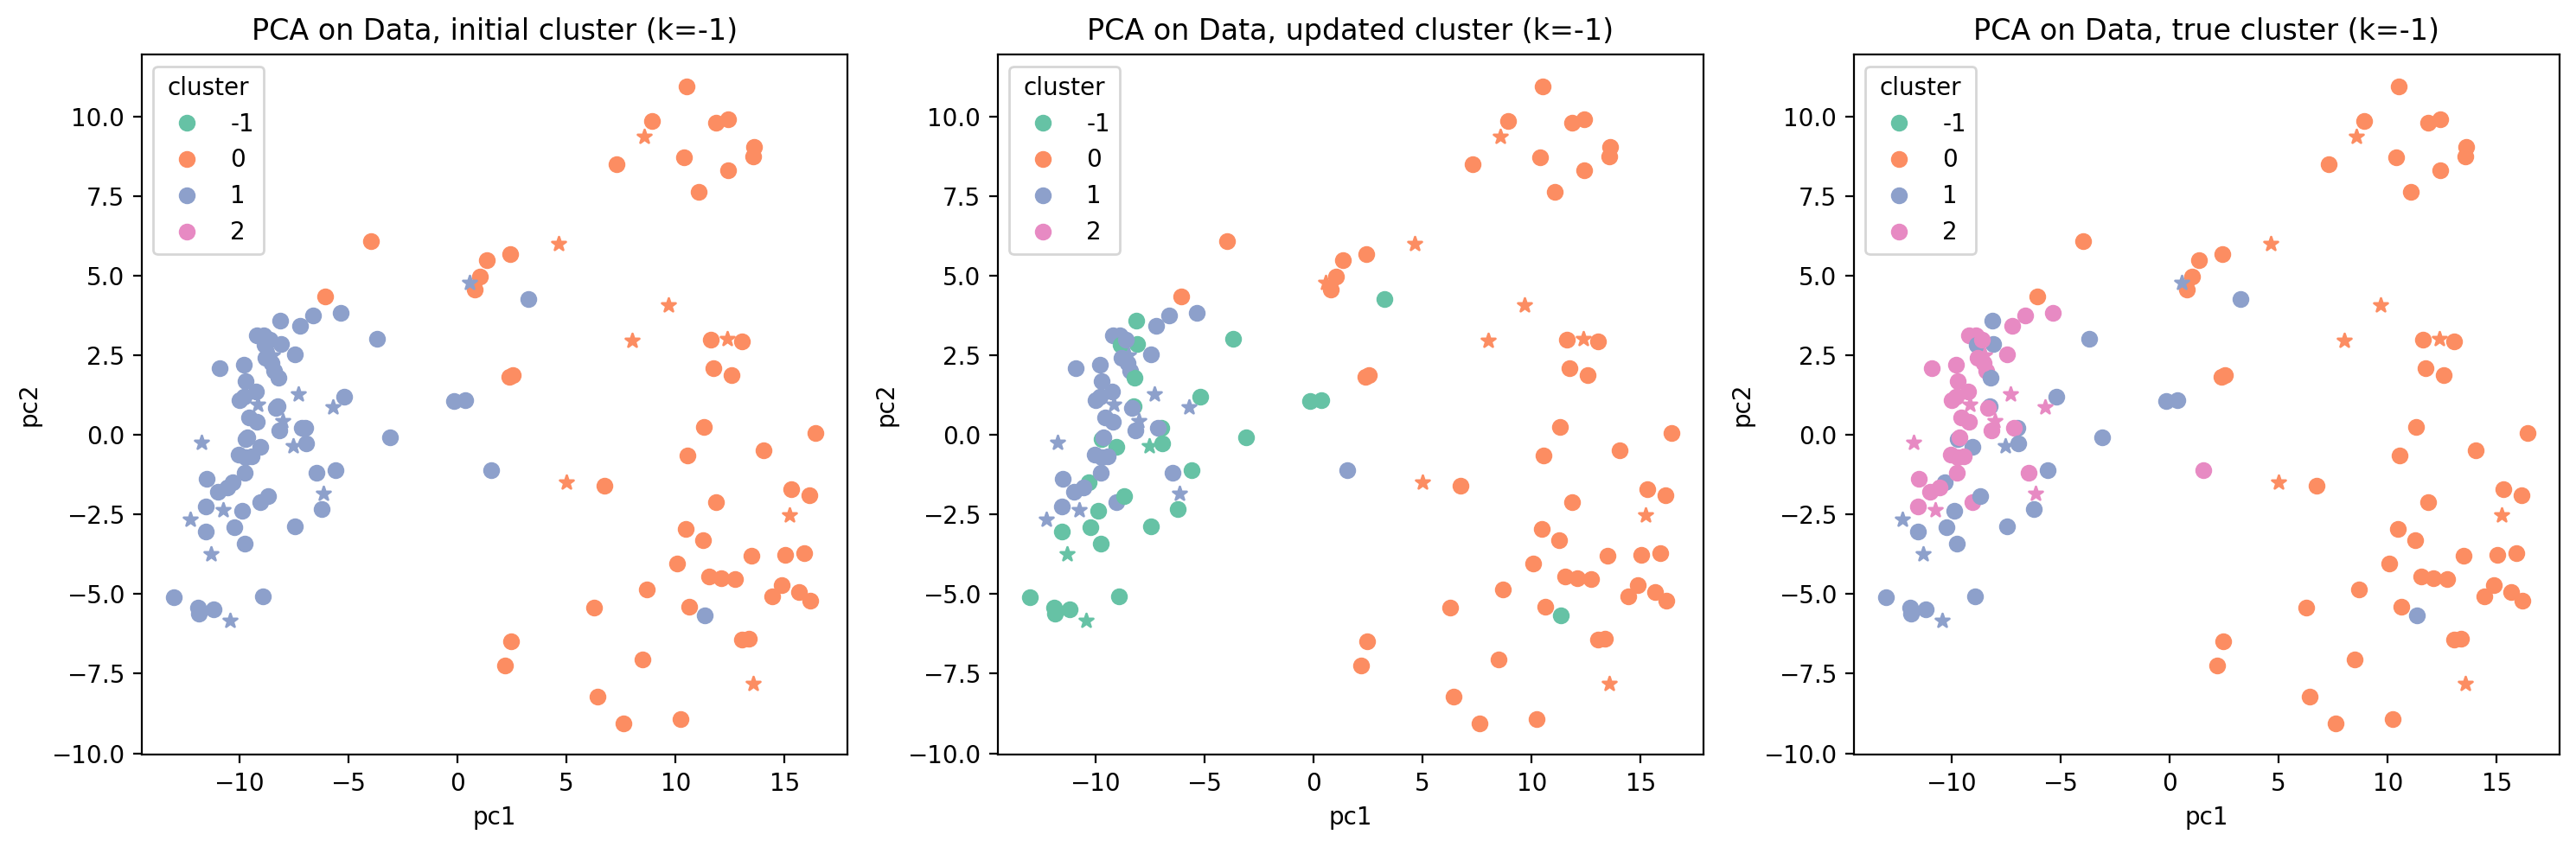

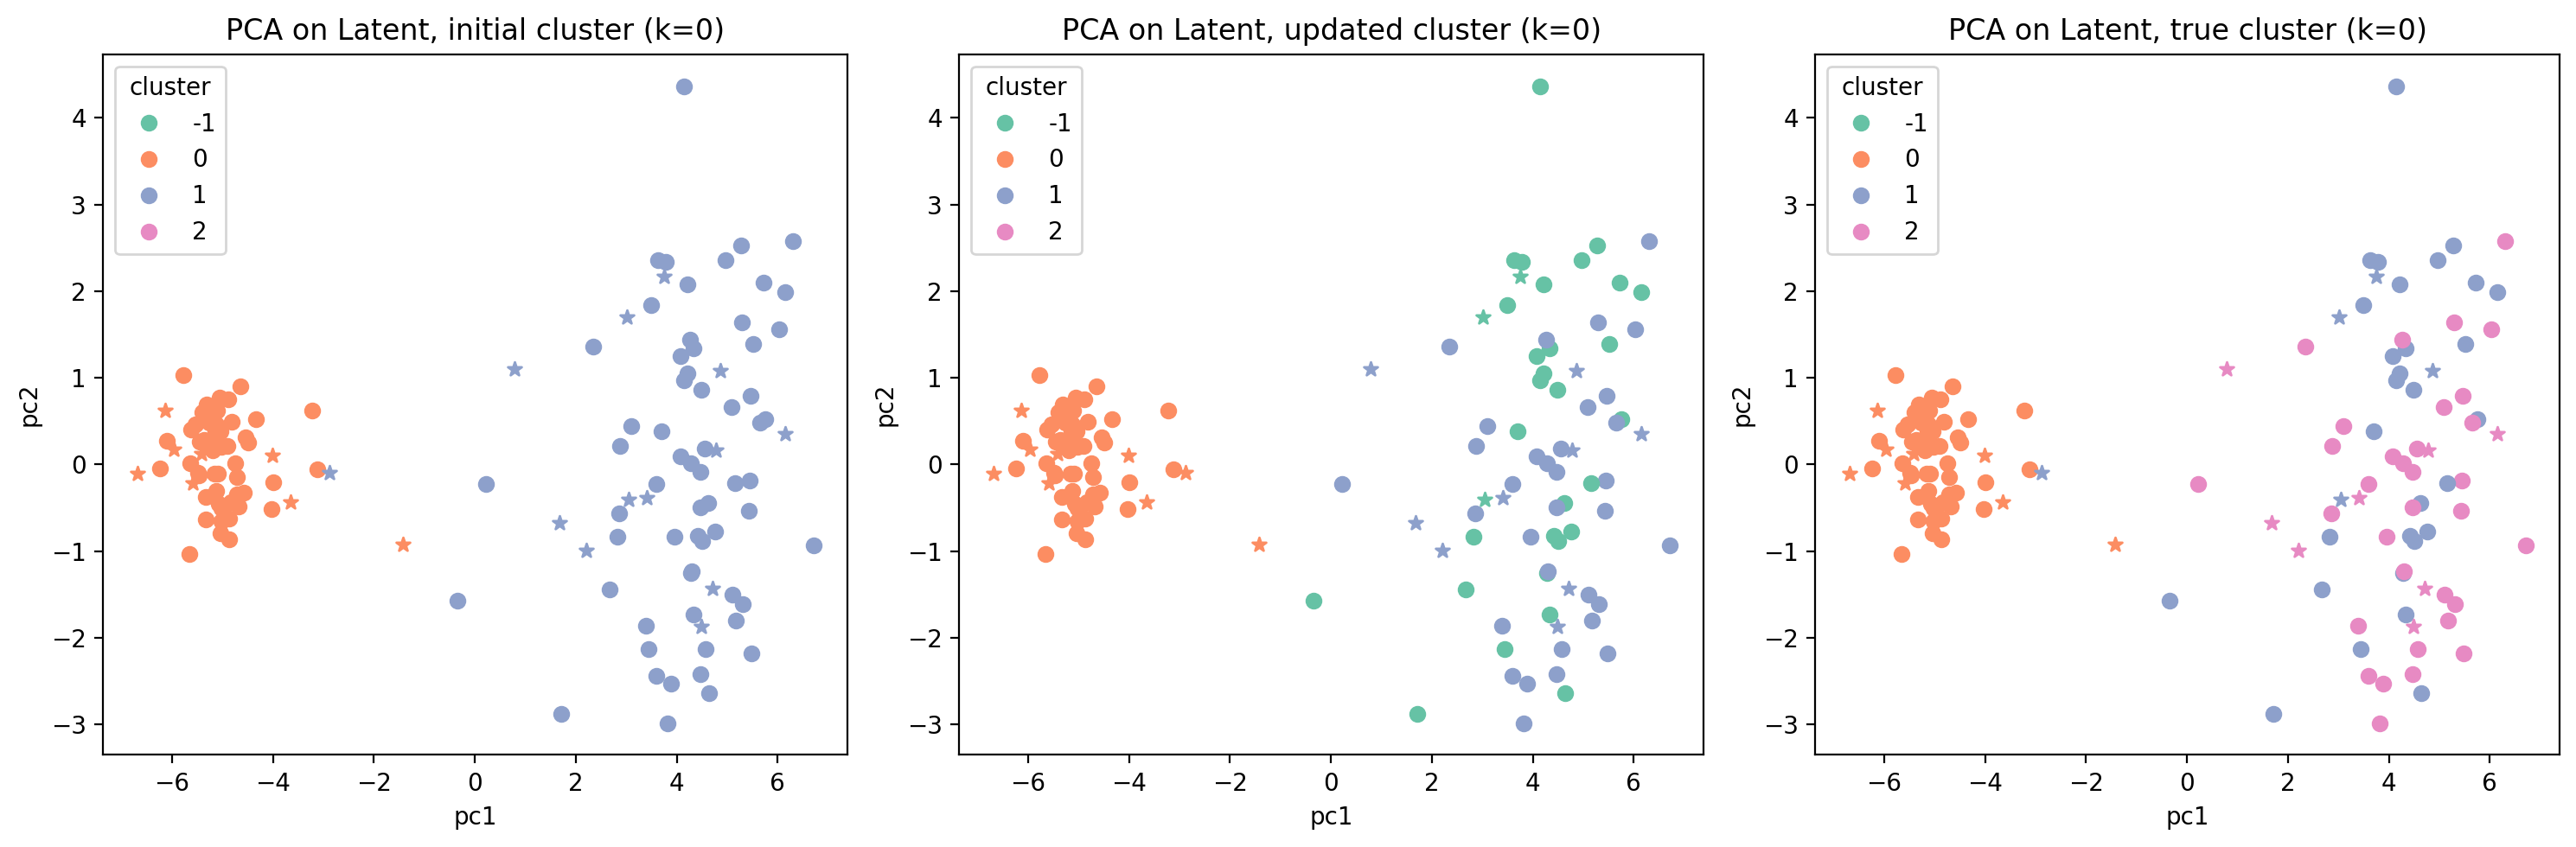

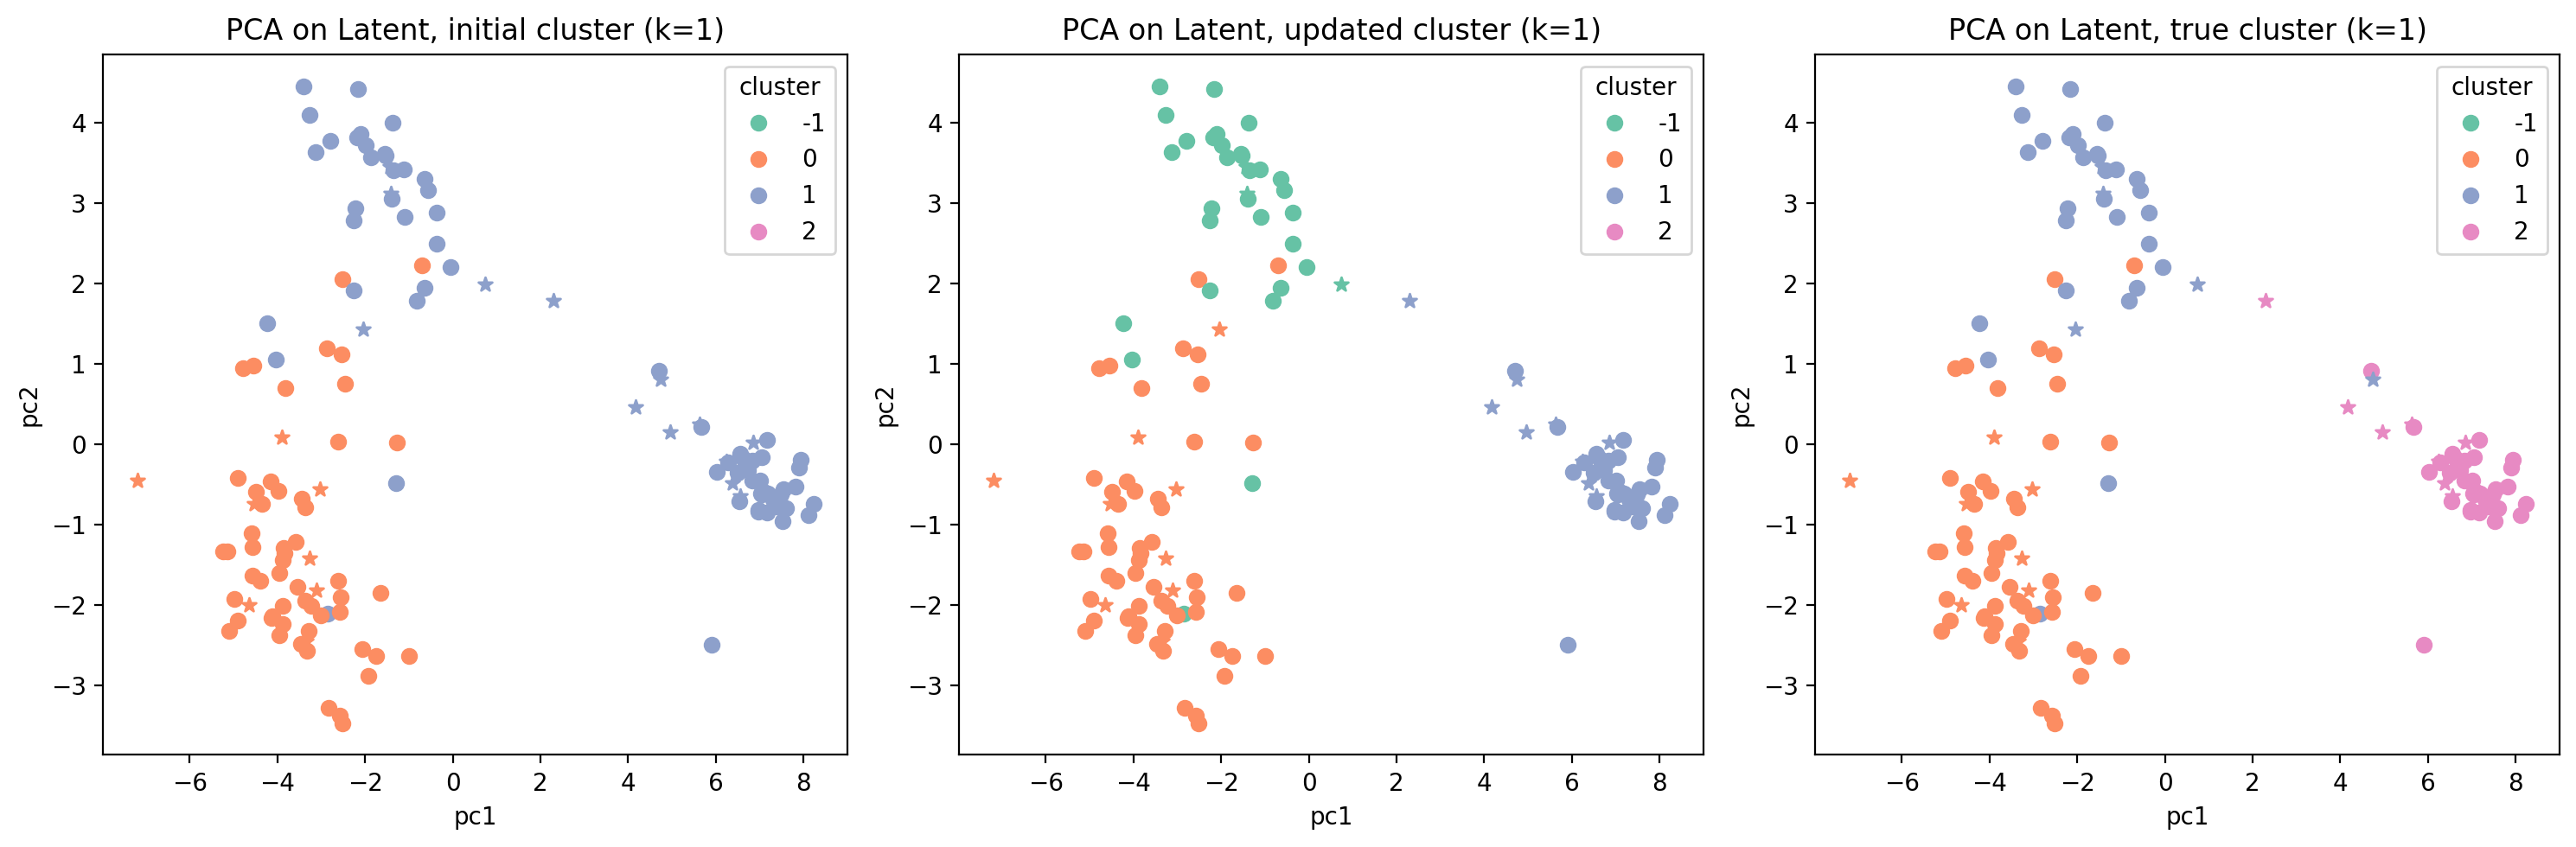

In [ ]:
for k in range(-1, CDPmodel.K):
    plot_c_PCA_latent_test(CDPmodel, device, n_rounds, c_latent_list, c_train, c_test, cdr_train_rslt_cluster, cdr_test_rslt_cluster, k=k, 
                       plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_c_latent_k{k}_test_data.png')
                       

### Losses:

In [ ]:
len(losses_train_hist_list)

2

In [ ]:
len(best_epos_list)

2

k = 0:
round 0:


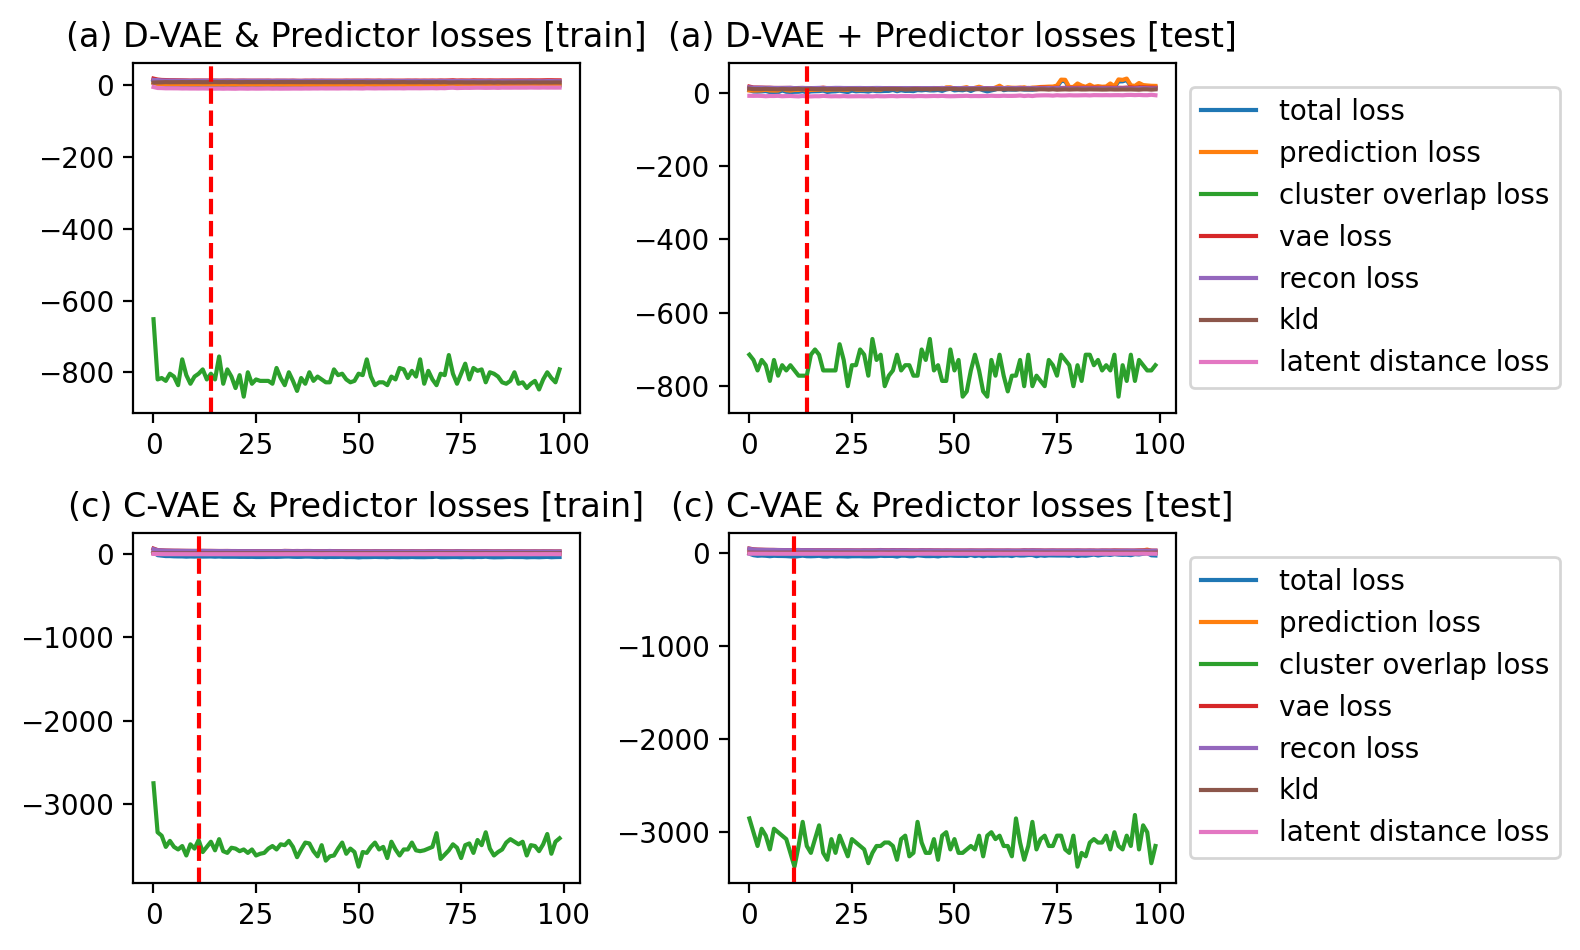

round 1:


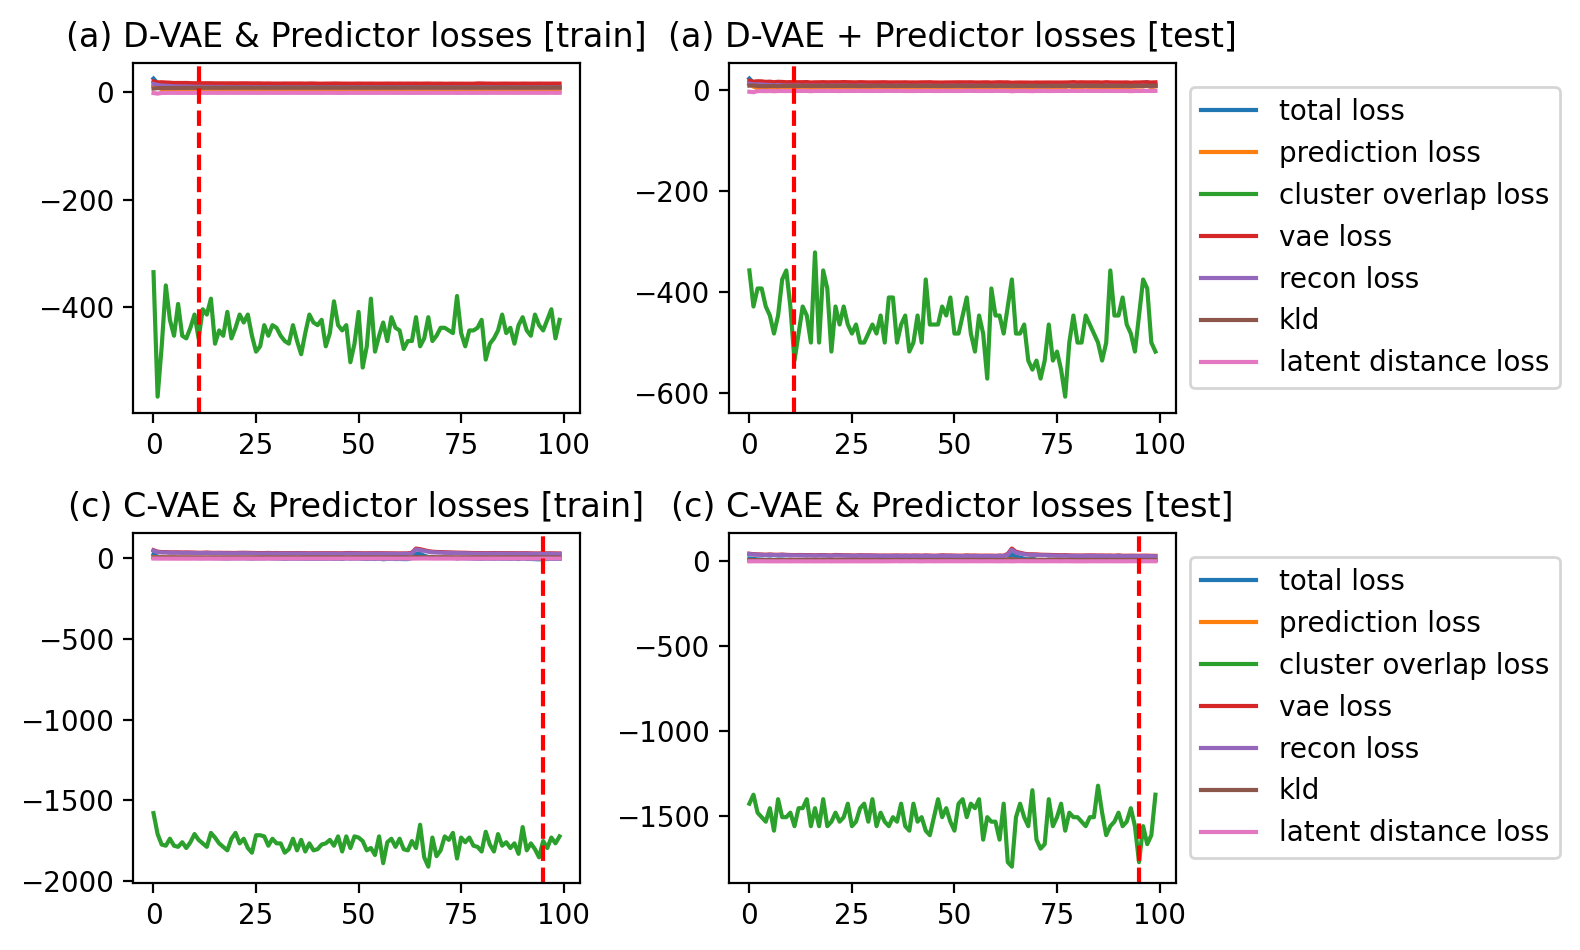

round 2:


IndexError: list index out of range

In [ ]:
for k in range(K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_training_losses_train_test_2cols(losses_train_hist_list[k][b], best_epoch_1round = best_epos_list[k][b],
                                              plot_save_path=f'{plot_folder}simu2_{num_cluster}clusters_losses_k{k}_b{b}.png')
        

k = 0:
round 0:


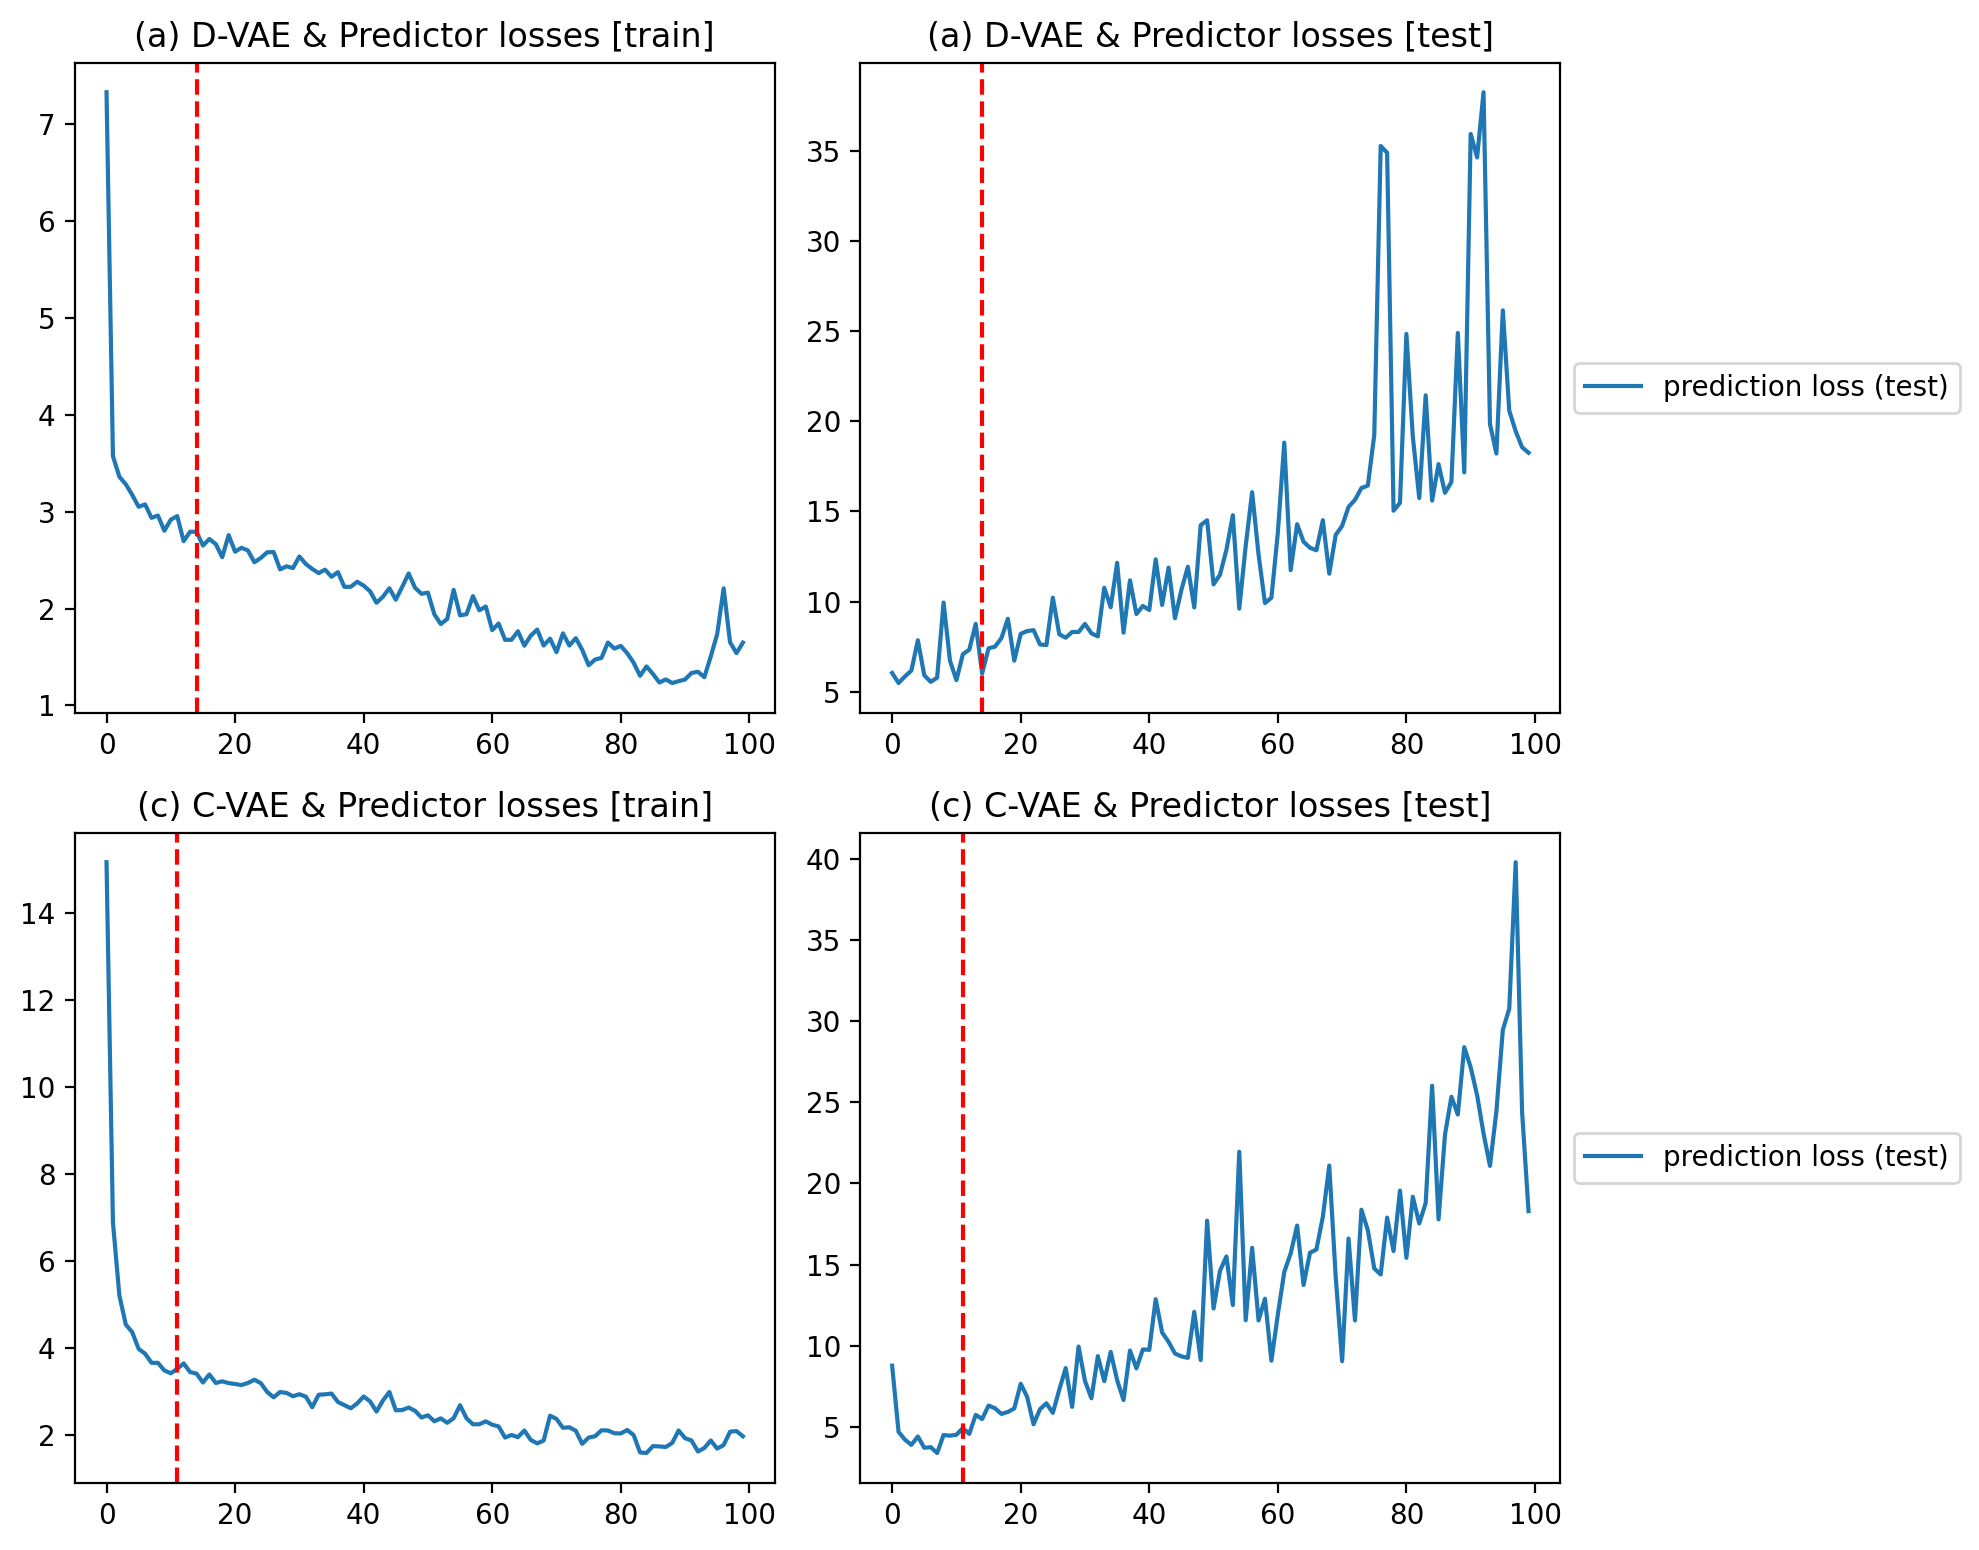

round 1:


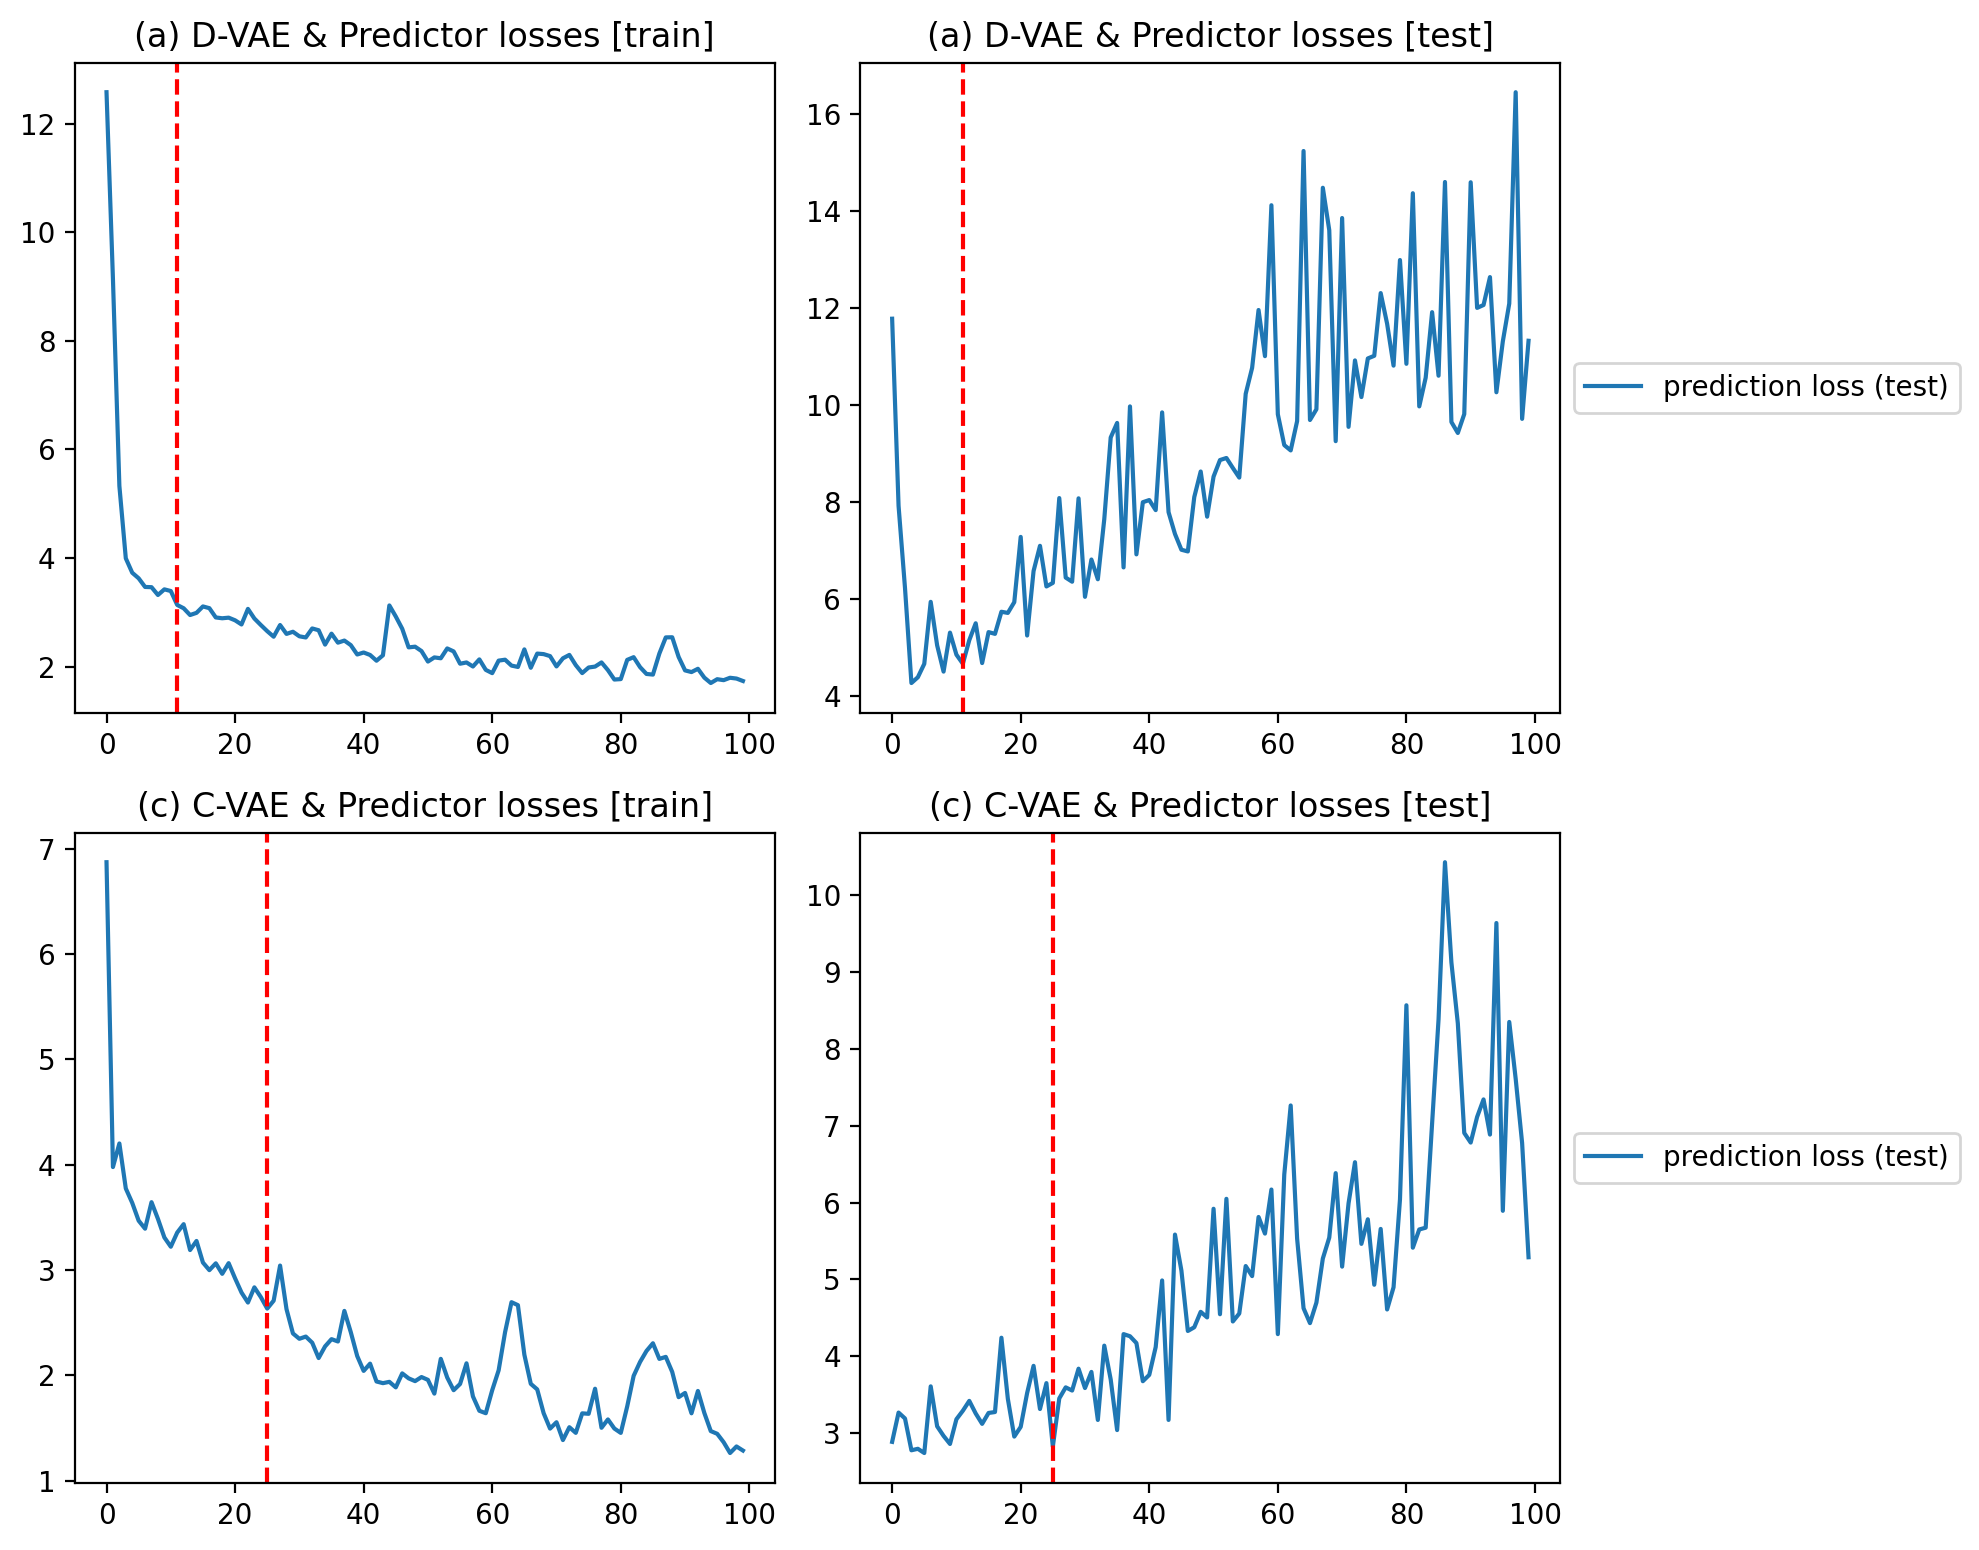

round 2:


IndexError: list index out of range

In [ ]:
for k in range(K):
    print(f'k = {k}:')
    for b in range(n_rounds):
        print(f'round {b}:')
        plot_predict_training_losses_train_test_2cols(losses_train_hist_list[k][b], best_epoch_1round = best_epos_list[k][b])

        